# Airlines Flight Data ETL Pipeline Demo

This notebook demonstrates the ETL (Extract, Transform, Load) process for converting flight prices from Indian Rupees (INR) to US Dollars (USD).

## Features
- 🔄 Load data from **Kaggle API** or local file
- 💱 Convert prices from INR to USD with real-time exchange rates
- 📊 Visualize price distributions and trends
- 📈 Generate insights and statistics


## 1. Setup and Imports


In [1]:
import pandas as pd
import requests
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# For Kaggle API support
try:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
    KAGGLE_AVAILABLE = True
    print("✓ kagglehub installed - Kaggle API available")
except ImportError:
    KAGGLE_AVAILABLE = False
    print("⚠ kagglehub not installed - Only local file loading available")
    print("  Install with: pip install kagglehub")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


### Data Source Options

This notebook supports two methods for loading data:

1. **Kaggle API (Recommended)**: Automatically fetches the latest data from Kaggle
   - Set `DATA_SOURCE = 'kaggle'` in the cell below
   - Requires: `pip install kagglehub`

2. **Local File**: Loads from a CSV file in the current directory
   - Set `DATA_SOURCE = 'local'` in the cell below
   - Requires: `airlines_flights_data.csv` in the same directory

**To switch between sources**, simply change the `DATA_SOURCE` variable in the next cell!


## 2. Extract: Load the Data


In [2]:
# Load the airlines flight data
# Choose your data source: 'kaggle' or 'local'
DATA_SOURCE = 'kaggle'  # Change to 'local' to use local file

if DATA_SOURCE == 'kaggle' and KAGGLE_AVAILABLE:
    print("Loading data from Kaggle API...")
    print("Dataset: rohitgrewal/airlines-flights-data")
    print()
    
    df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "rohitgrewal/airlines-flights-data",
        "",
    )
    print("✓ Data loaded from Kaggle successfully!")
    
elif DATA_SOURCE == 'kaggle' and not KAGGLE_AVAILABLE:
    print("❌ Kaggle API requested but kagglehub not installed!")
    print("Falling back to local file...")
    df = pd.read_csv('airlines_flights_data.csv')
    
else:  # local
    print("Loading data from local file...")
    df = pd.read_csv('airlines_flights_data.csv')
    print("✓ Data loaded from local file successfully!")

print(f"\nTotal records: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Total records: 300,153

Columns: ['index', 'airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'price']

First few rows:


,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [3]:
# Data info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [4]:
# Basic statistics on original prices (INR)
print("Price Statistics (INR):")
print(df['price'].describe())


Price Statistics (INR):
count    300153.000000
mean      20889.660523
std       22697.767366
min        1105.000000
25%        4783.000000
50%        7425.000000
75%       42521.000000
max      123071.000000
Name: price, dtype: float64


## 3. Transform: Get Exchange Rate and Convert Prices


In [5]:
# Function to get current exchange rate
def get_exchange_rate():
    """
    Fetch current INR to USD exchange rate
    """
    try:
        response = requests.get(
            'https://api.exchangerate-api.com/v4/latest/INR',
            timeout=10
        )
        response.raise_for_status()
        rate = response.json()['rates']['USD']
        print(f"✓ Current exchange rate: 1 INR = ${rate:.4f} USD")
        return rate
    except Exception as e:
        print(f"⚠ Failed to fetch exchange rate: {e}")
        fallback_rate = 0.012
        print(f"Using fallback rate: 1 INR = ${fallback_rate} USD")
        return fallback_rate

# Get exchange rate
exchange_rate = get_exchange_rate()


✓ Current exchange rate: 1 INR = $0.0113 USD


In [6]:
# Transform: Convert prices from INR to USD
df['price_inr'] = df['price']
df['price_usd'] = (df['price_inr'] * exchange_rate).round(2)
df['currency'] = 'USD'
df['exchange_rate_used'] = exchange_rate
df['conversion_date'] = datetime.now().strftime('%Y-%m-%d')

print("✓ Transformation complete!")
print(f"\nSample of transformed data:")
df[['airline', 'source_city', 'destination_city', 'price_inr', 'price_usd', 'currency']].head(10)


✓ Transformation complete!

Sample of transformed data:


,airline,source_city,destination_city,price_inr,price_usd,currency
0,SpiceJet,Delhi,Mumbai,5953,67.27,USD
1,SpiceJet,Delhi,Mumbai,5953,67.27,USD
2,AirAsia,Delhi,Mumbai,5956,67.30,USD
3,Vistara,Delhi,Mumbai,5955,67.29,USD
4,Vistara,Delhi,Mumbai,5955,67.29,USD
5,Vistara,Delhi,Mumbai,5955,67.29,USD
6,Vistara,Delhi,Mumbai,6060,68.48,USD
7,Vistara,Delhi,Mumbai,6060,68.48,USD
8,GO_FIRST,Delhi,Mumbai,5954,67.28,USD
9,GO_FIRST,Delhi,Mumbai,5954,67.28,USD


## 4. Data Analysis: Compare INR vs USD Prices


In [7]:
# Price statistics comparison
print("="*60)
print("PRICE STATISTICS COMPARISON")
print("="*60)

print("\nOriginal Prices (INR):")
print(f"  Minimum:  ₹{df['price_inr'].min():,.2f}")
print(f"  Maximum:  ₹{df['price_inr'].max():,.2f}")
print(f"  Average:  ₹{df['price_inr'].mean():,.2f}")
print(f"  Median:   ₹{df['price_inr'].median():,.2f}")

print("\nConverted Prices (USD):")
print(f"  Minimum:  ${df['price_usd'].min():,.2f}")
print(f"  Maximum:  ${df['price_usd'].max():,.2f}")
print(f"  Average:  ${df['price_usd'].mean():,.2f}")
print(f"  Median:   ${df['price_usd'].median():,.2f}")


PRICE STATISTICS COMPARISON

Original Prices (INR):
  Minimum:  ₹1,105.00
  Maximum:  ₹123,071.00
  Average:  ₹20,889.66
  Median:   ₹7,425.00

Converted Prices (USD):
  Minimum:  $12.49
  Maximum:  $1,390.70
  Average:  $236.05
  Median:   $83.90


/var/folders/72/w6xqf_5n2kz1c4j95wp104v40000gn/T/ipykernel_90595/381571103.py:20: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


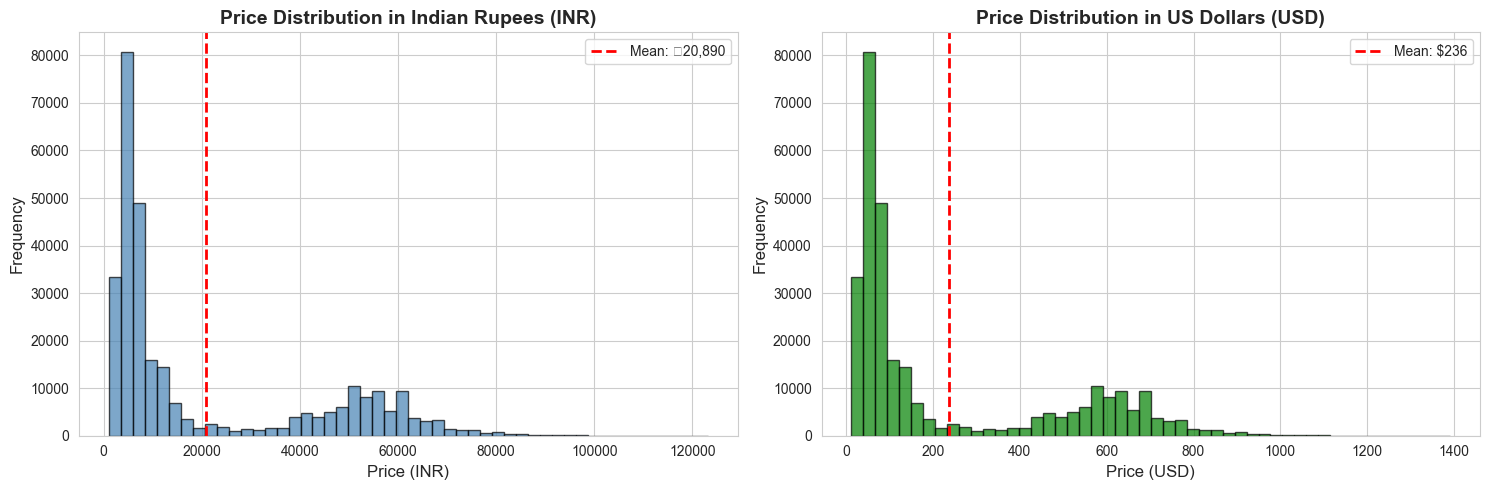

In [8]:
# Visualize price distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# INR distribution
axes[0].hist(df['price_inr'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price (INR)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Price Distribution in Indian Rupees (INR)', fontsize=14, fontweight='bold')
axes[0].axvline(df['price_inr'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ₹{df["price_inr"].mean():,.0f}')
axes[0].legend()

# USD distribution
axes[1].hist(df['price_usd'], bins=50, color='green', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Price (USD)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Price Distribution in US Dollars (USD)', fontsize=14, fontweight='bold')
axes[1].axvline(df['price_usd'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${df["price_usd"].mean():,.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()


In [9]:
# Price comparison by airline
airline_prices = df.groupby('airline').agg({
    'price_inr': 'mean',
    'price_usd': 'mean'
}).round(2).sort_values('price_usd', ascending=False)

print("Average Prices by Airline:")
print(airline_prices)


Average Prices by Airline:
           price_inr  price_usd
airline                        
Vistara     30396.54     343.48
Air_India   23507.02     265.63
SpiceJet     6179.28      69.83
GO_FIRST     5652.01      63.87
Indigo       5324.22      60.16
AirAsia      4091.07      46.23


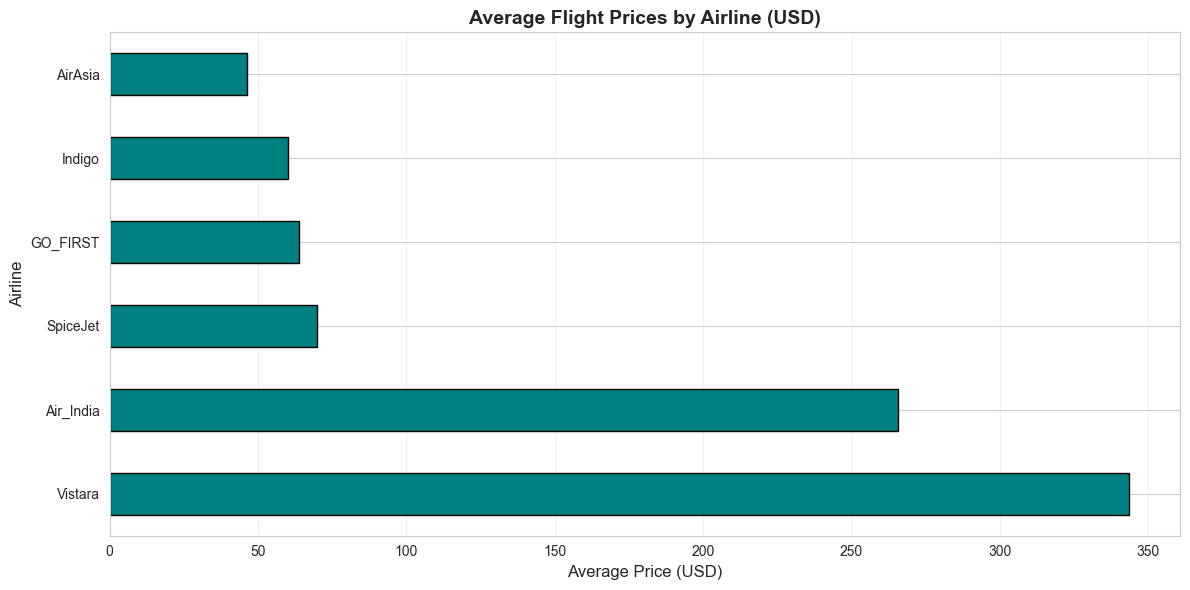

In [10]:
# Visualize average prices by airline
fig, ax = plt.subplots(figsize=(12, 6))

airline_prices['price_usd'].plot(kind='barh', color='teal', edgecolor='black', ax=ax)
ax.set_xlabel('Average Price (USD)', fontsize=12)
ax.set_ylabel('Airline', fontsize=12)
ax.set_title('Average Flight Prices by Airline (USD)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
# Price by class comparison
class_prices = df.groupby('class').agg({
    'price_usd': ['mean', 'min', 'max', 'count']
}).round(2)

print("Price Statistics by Class (USD):")
print(class_prices)


Price Statistics by Class (USD):
         price_usd                         
              mean     min      max   count
class                                      
Business    593.70  135.60  1390.70   93487
Economy      74.27   12.49   478.54  206666


## 5. Load: Save Transformed Data


In [12]:
# Reorder columns for better readability
cols = list(df.columns)
for col in ['price_inr', 'price_usd', 'currency', 'exchange_rate_used', 'conversion_date']:
    if col in cols:
        cols.remove(col)

price_idx = cols.index('price')
new_cols = (cols[:price_idx+1] + 
           ['price_inr', 'price_usd', 'currency', 'exchange_rate_used', 'conversion_date'] + 
           cols[price_idx+1:])

df_final = df[new_cols]

# Save to CSV
output_file = 'airlines_flights_data_usd.csv'
df_final.to_csv(output_file, index=False)

print(f"✓ Data saved to: {output_file}")
print(f"✓ Total records: {len(df_final):,}")
print(f"✓ Total columns: {len(df_final.columns)}")


✓ Data saved to: airlines_flights_data_usd.csv
✓ Total records: 300,153
✓ Total columns: 17


In [13]:
# Display sample of final output
print("Sample of final transformed data:")
df_final.head(10)


Sample of final transformed data:


,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,price_inr,price_usd,currency,exchange_rate_used,conversion_date
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,5953,67.27,USD,0.0113,2025-11-12
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,5953,67.27,USD,0.0113,2025-11-12
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,5956,67.30,USD,0.0113,2025-11-12
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,5955,67.29,USD,0.0113,2025-11-12
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,5955,67.29,USD,0.0113,2025-11-12
5,5,Vistara,UK-945,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.33,1,5955,5955,67.29,USD,0.0113,2025-11-12
6,6,Vistara,UK-927,Delhi,Morning,zero,Morning,Mumbai,Economy,2.08,1,6060,6060,68.48,USD,0.0113,2025-11-12
7,7,Vistara,UK-951,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.17,1,6060,6060,68.48,USD,0.0113,2025-11-12
8,8,GO_FIRST,G8-334,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.17,1,5954,5954,67.28,USD,0.0113,2025-11-12
9,9,GO_FIRST,G8-336,Delhi,Afternoon,zero,Evening,Mumbai,Economy,2.25,1,5954,5954,67.28,USD,0.0113,2025-11-12


## 6. Summary

The ETL pipeline has successfully:
1. **Extracted** flight data from the CSV file
2. **Transformed** prices from INR to USD using current exchange rates
3. **Loaded** the transformed data to a new CSV file

The output file contains all original columns plus:
- `price_inr`: Original price in Indian Rupees
- `price_usd`: Converted price in US Dollars
- `currency`: Currency code (USD)
- `exchange_rate_used`: The exchange rate used for conversion
- `conversion_date`: Date of conversion
